In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The asymptotic formulae for q tilde and some plotting

In [2]:
def gpdf(qq,muprime,sig,mu):
    cut = mu**2/sig**2
    
    # 1/√(2π)
    standard_pre = 1/np.sqrt(2*np.pi)

    # compute the arg of the exponential
    muprime_muhat1_minus_over_sig = (qq - (mu**2/sig**2 - (2*mu*muprime/sig**2))  )/(2*mu/sig)
    muprime_muhat2_minus_over_sig = (np.sqrt(qq)-(mu-muprime)/sig) 

    # chose which one
    muhat_over_sig = np.where(qq>cut,muprime_muhat1_minus_over_sig,muprime_muhat2_minus_over_sig)

    # exp(-0.5 (mu^-mu'))
    arg   = -0.5*(muhat_over_sig)**2

    # compute the jacobian 
    # 1/ sigma * dµ^/dq
    oos_j1 =  1/(2*mu/sig)
    oos_j2 =  1/(2*np.sqrt(qq))
    
    # chose which one
    one_over_sig_jacobian = np.where(qq>cut,oos_j1,oos_j2)

    # compute the reparametrized gaussian
    return standard_pre * np.exp(arg)*one_over_sig_jacobian

def plot(axarr,mu,muprime,data,c = None):
    maxv  = 8.8

    bins = np.linspace(0,10,26)
    qq = np.linspace(0,10,100)
    sigma,bestfits,q = data

    asimov = mu**2/sigma**2
    y  = gpdf(qq,muprime,sigma,mu)
    
    ax1 = axarr[0,0]
    ax1.hist(q,bins = bins, density = True, histtype = 'step', edgecolor = c)
    ax1.plot(qq,y, c= c, linestyle = 'dashed')
    ax1.semilogy()
    ax1.set_ylim(1e-3,2e0)
    ax1.set_xlim(0,maxv)
    ax1.vlines(asimov,0,2e0, edgecolors = c)
    
    ax2 = axarr[0,1]
    ax2.scatter(bestfits,q, alpha = 0.1, c = c)
    ax2.set_xlim(-5,5)

    
    ax3 = axarr[1,1]
    ax3.hist(bestfits,density = True, bins = np.linspace(-5,5,26), histtype = 'step', edgecolor = c)
    ax3.set_ylim(0,0.85)

## Running "Toys" using the assumed asymptotic behavior using sigmas fine-tuned to reproduce fig 5b in CCGV

In [3]:
def teststat_for_asymptotics(muhat,mu,sig):
    cut = mu**2/sig**2
    
    q1 = (mu-muhat)**2/(sig**2) - (0-muhat)**2/(sig**2)
    q2 = (mu-muhat)**2/(sig**2)
    q3 = 0

    qt = np.where(muhat<0,q1,q2)
    q = np.where(muhat<mu,qt,q3)
    return q

def get_fits_and_stats_from_asymptotics(mu,muprime,ntoys):
    sigma = {
        1: {1: 1/np.sqrt(1.48), # see below where the magic numbers come from
            0: 1/np.sqrt(1.90)
        }
    }
    sigma = sigma[mu][muprime]
    bestfits = np.random.normal(muprime,sigma,size = ntoys)
    q = teststat_for_asymptotics(bestfits,mu,sigma)
    return sigma,bestfits,q


In [4]:
bonly_fake_toys = get_fits_and_stats_from_asymptotics(mu = 1.0,muprime = 0.0, ntoys = 20000)
sb_fake_toys = get_fits_and_stats_from_asymptotics(mu = 1.0,muprime = 1.0, ntoys = 20000)

/Users/lukasheinrich/Code/pyhfdev/dev/pyhfdevenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


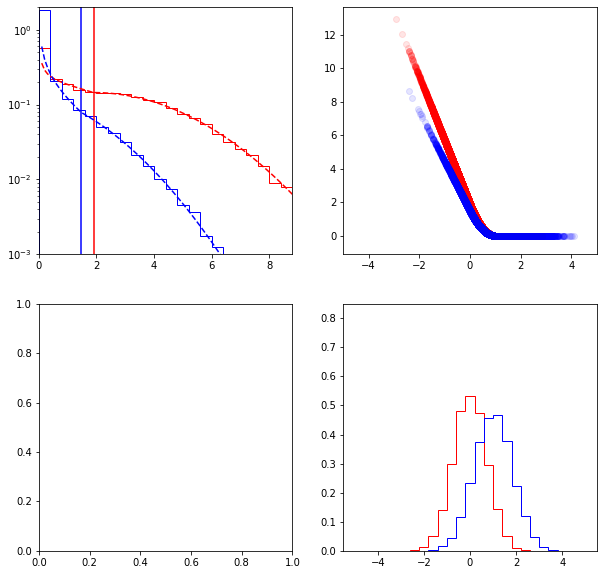

In [5]:
f,axarr = plt.subplots(2,2)
plot(axarr,1.0,0.0,bonly_fake_toys, c = 'r')
plot(axarr,1.0,1.0,sb_fake_toys , c = 'b')
f.set_size_inches(10,10)

## Running actual toys using pyhf

In [6]:
def teststat_for_real(mu, data, pdf, init_pars, par_bounds):
    import pyhf
    
    tensorlib, optimizer = pyhf.get_backend()
    mubhathat, fixed_poi_fit_lhood_val = pyhf.infer.mle.fixed_poi_fit(
        mu, data, pdf, init_pars, par_bounds, return_fitted_val=True
    )
    muhatbhat, unconstrained_fit_lhood_val = pyhf.infer.mle.fit(
        data, pdf, init_pars, par_bounds, return_fitted_val=True
    )
    qmu = fixed_poi_fit_lhood_val - unconstrained_fit_lhood_val
    qmu = tensorlib.where(
        muhatbhat[pdf.config.poi_index] > mu, tensorlib.astensor(0.0), qmu
    )[0]
    return tensorlib.clip(qmu, 0, max_value=None)

def get_fits_and_stats_for_real(mu,muprime,ntoys):
    # we set up a pyhf models with the parameters from the paper
    # s = 6, b = 9, tau = 1 -> deltab = np.sqrt(b)
    import pyhf
    a,b,c = 6,9,3
    m = pyhf.simplemodels.hepdata_like([a],[b],[c])
    
    
    # generate some toys
    pars = m.config.suggested_init()
    pars[m.config.poi_index] = muprime
    toys = m.make_pdf(pyhf.tensorlib.astensor(pars)).sample((ntoys,))
    
    # collect the teststats and bestfit values for the joint distribution
    bestfits  = []
    teststats = []
    
    for t in toys:
        #if we want to have the "real" µ^ we need to loosen
        #the bounds to allow for negative µ^
        
        bounds =  m.config.suggested_bounds()
        bounds[m.config.poi_index] = [-10,10]

        bf  = pyhf.infer.mle.fit(t, m, m.config.suggested_init(), bounds)
        bf  = bf[m.config.poi_index]

        # here we keep the natural bounds which effectively implements q_µ~
        qmu = teststat_for_real(mu,t,m,m.config.suggested_init(),m.config.suggested_bounds())
        bestfits.append(bf)
        teststats.append(qmu)
        
    #estimating sigma 
    #here comes the crucial part:
    #we use different methods depending on
    #what combination of mu, muprime we are in
    if mu == 1 and muprime == 0:
        print('from a)')
        # here we use asimov data ono the nominal b-only parameters
        # in actual pyhf we will do a constrained fit at µ'=0 here and
        # go from there
        asimov_data = m.expected_data(pars)
        asimov = pyhf.infer.test_statistics.qmu(mu,asimov_data,m,m.config.suggested_init(),m.config.suggested_bounds())
        sigma = mu/np.sqrt(asimov)
    else:
        print('from b)')
        sigma = np.std(bestfits)
    print('sigma',mu,muprime,sigma,1/sigma**2)
    return sigma,bestfits,teststats


In [7]:
bonly_real_toys = get_fits_and_stats_for_real(mu = 1.0,muprime = 0.0, ntoys = 5000)
sb_real_toys = get_fits_and_stats_for_real(mu = 1.0,muprime = 1.0, ntoys = 5000)

/Users/lukasheinrich/Code/pyhfdev/dev/pyhfsrc/src/pyhf/tensor/numpy_backend.py:253: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


from a)
sigma 1.0 0.0 [0.72498212] [1.90259087]
from b)
sigma 1.0 1.0 0.8123183039757756 1.515470620511855


/Users/lukasheinrich/Code/pyhfdev/dev/pyhfdevenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


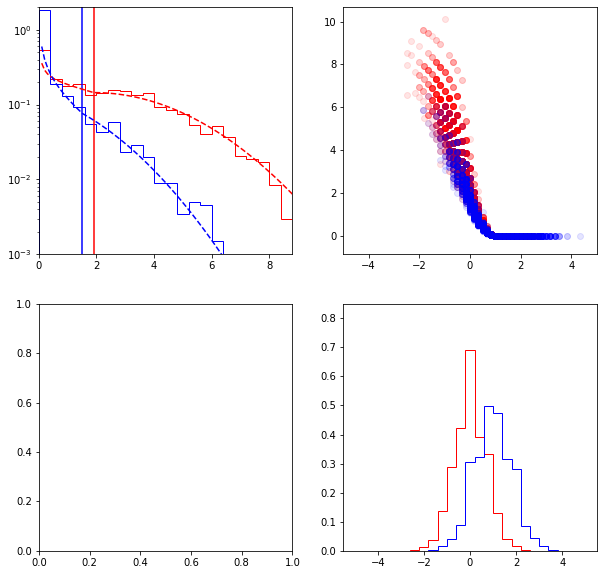

In [8]:
f,axarr = plt.subplots(2,2)
plot(axarr,1.0,0.0,bonly_real_toys, c = 'r')
plot(axarr,1.0,1.0,sb_real_toys, c = 'b')
f.set_size_inches(10,10)